<a href="https://colab.research.google.com/github/MarcoMartini75/dati/blob/master/lstm_title_sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np 
import pandas as pd 
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.models import Sequential
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [2]:
! git clone --recursive https://github.com/MarcoMartini75/dati

Cloning into 'dati'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 15 (delta 6), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (15/15), done.


In [3]:
df_s = pd.read_csv("/content/dati/data_feelings.csv", index_col = 0)
df_s.head(10)

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Polarity_Score_title,Negative_Score_title,Neutral_Score_title,Positive_Score_title,feeling_title,Polarity_Score_text,Negative_Score_text,Neutral_Score_text,Positive_Score_text,feeling_text
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,NaN,NaN,NaN,NaN,NaN,0.8932,0.000,0.272,0.728,pos
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,NaN,NaN,NaN,NaN,NaN,0.9729,0.000,0.664,0.336,pos
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,0.0000,0.0,1.000,0.000,neu,0.9427,0.027,0.792,0.181,pos
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,0.5093,0.0,0.378,0.622,pos,0.5727,0.226,0.340,0.434,pos
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,0.3182,0.0,0.303,0.697,pos,0.9291,0.000,0.700,0.300,pos
5,1080,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",2,0,4,General,Dresses,Dresses,0.0000,0.0,1.000,0.000,neu,0.9419,0.000,0.853,0.147,pos
6,858,39,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,5,1,1,General Petite,Tops,Knits,0.5106,0.0,0.377,0.623,pos,0.8004,0.023,0.881,0.096,pos
7,858,39,"Shimmer, surprisingly goes with lots","I ordered this in carbon for store pick up, an...",4,1,4,General Petite,Tops,Knits,0.2960,0.0,0.645,0.355,pos,-0.0909,0.046,0.901,0.053,neg
8,1077,24,Flattering,I love this dress. i usually get an xs but it ...,5,1,0,General,Dresses,Dresses,0.3182,0.0,0.000,1.000,pos,0.7175,0.000,0.818,0.182,pos
9,1077,34,Such a fun dress!,"I'm 5""5' and 125 lbs. i ordered the s petite t...",5,1,0,General,Dresses,Dresses,0.5562,0.0,0.358,0.642,pos,-0.3724,0.120,0.753,0.126,neg


In [0]:
data = df_s.dropna(subset=["Title"])

In [5]:
data["feeling_title"].value_counts()

pos    13590
neu     4740
neg     1346
Name: feeling_title, dtype: int64

In [6]:
 data["feeling_title"]= data["feeling_title"].replace(['neg','neu','pos'],['0','1','2']).astype(float)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [7]:
data["feeling_title"].value_counts()

2.0    13590
1.0     4740
0.0     1346
Name: feeling_title, dtype: int64

In [8]:
n_most_common_words = 8000
max_len = 130
tokenizer = Tokenizer(num_words=n_most_common_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(data['Title'].values)
sequences = tokenizer.texts_to_sequences(data['Title'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X = pad_sequences(sequences, maxlen=max_len)

Found 3829 unique tokens.


In [0]:
y_int = data["feeling_title"]

In [0]:
from keras.utils import to_categorical
y_binary = to_categorical(y_int)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X , y_binary, test_size=0.25, random_state=42)

In [0]:
epochs = 25
emb_dim = 128
batch_size = 256

In [14]:
print((X_train.shape, y_train.shape, X_test.shape, y_test.shape))

model = Sequential()
model.add(Embedding(n_most_common_words, emb_dim, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.7))
model.add(LSTM(64, dropout=0.7, recurrent_dropout=0.7))
model.add(Dense(3, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
print(model.summary())
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',patience=7, min_delta=0.0001)])

((14757, 130), (14757, 3), (4919, 130), (4919, 3))
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 130, 128)          1024000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 130, 128)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 195       
Total params: 1,073,603
Trainable params: 1,073,603
Non-trainable params: 0
_________________________________________________________________
None
Instructions for upda

In [15]:
accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

4919/4919 [==============================] - 4s 799us/step
Test set
  Loss: 0.160
  Accuracy: 0.958


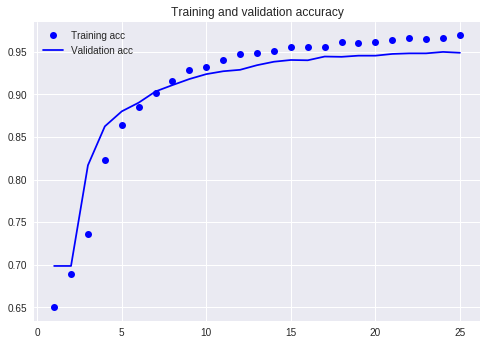

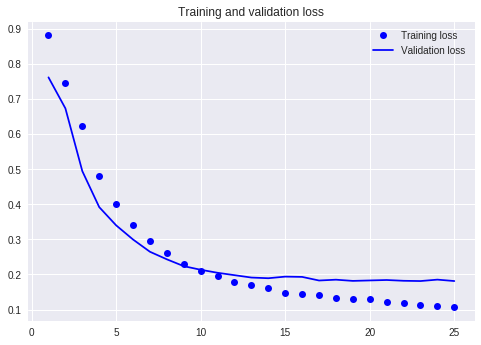

In [16]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [17]:
txt = ["I don't know"]
seq = tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_len)
pred = model.predict(padded)
labels = ['neg', 'neu', 'pos']
print(pred, labels[np.argmax(pred)])

[[7.0438255e-03 9.9269569e-01 2.6051136e-04]] neu


In [18]:
txt = ["good"]
seq = tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_len)
pred = model.predict(padded)
labels = ['neg', 'neu', 'pos']
print(pred, labels[np.argmax(pred)])

[[0.0053072  0.00800325 0.98668957]] pos


In [19]:
txt = ["bad"]
seq = tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_len)
pred = model.predict(padded)
labels = ['neg', 'neu', 'pos']
print(pred, labels[np.argmax(pred)])

[[0.988596   0.00481329 0.00659061]] neg


In [20]:
test_pred = model.predict(X_test)
scores = model.evaluate(X_test, y_test, verbose=0)
print("Perte: %.2f Erreur: %.2f%%" % (scores[0], 100-scores[1]*100))

Perte: 0.16 Erreur: 4.23%


In [0]:
pred = test_pred.argmax(axis=1)
y = y_test.argmax(axis=1)

In [22]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(y, pred)

print(cnf_matrix)

[[ 237   36   53]
 [  14 1145   45]
 [  23   37 3329]]


In [23]:
from sklearn.metrics import classification_report

print( classification_report(y, pred) )

              precision    recall  f1-score   support

           0       0.86      0.73      0.79       326
           1       0.94      0.95      0.95      1204
           2       0.97      0.98      0.98      3389

   micro avg       0.96      0.96      0.96      4919
   macro avg       0.93      0.89      0.90      4919
weighted avg       0.96      0.96      0.96      4919

